Hypothesis 1: A gender classifier trained on a gender balanced dataset will have more consistent
performance than a gender classifier trained on a gender unbalanced dataset.

Particularly, in this experiment, we will initially show the original distributions of the original dataset, including races,
gender and ages. Then we will resample the dataset to produce a balanced one and the unbalanced one(73% male and 27% female)
in order to show that the unbalanced dataset can negatively affect the performance of the model.

My result shows that the female group is signigicantly misclassified in the model which has been trained with the undbalanced dataset. 

## Setup

__Install and import dependencies__

In [7]:
'''Run the comments below if you have not installed those libraries yet'''
#!{sys.executable} -m pip install tensorflow==2.4
#!{sys.executable} -m pip install plotly # Used to create charts in analysis section
#!{sys.executable} -m pip install scikit-learn


import sys
import os

import pandas as pd
import numpy as np

import tensorflow as tf
import PIL # Python Image Library
from IPython.display import Image, display # To show images

import glob
import plotly.express as px # For histograms
import plotly.graph_objects as go # For pie charts
from sklearn.metrics import precision_score, recall_score # For performance metrics

#from sklearn.utils import shuffle

Define constants

In this part, I added dataset_dict in order to use the parse_dataset function in the next cell. The rest is the same.

In [8]:
dataset_folder_name = 'UTKFace'

# Label locations in the filename
AGE_INDEX = 0
GENDER_INDEX = 1
RACE_INDEX = 2

# Class labels
GENDER_MALE = 0
GENDER_FEMALE = 1
RACE_WHITE = 0
RACE_BLACK = 1
RACE_ASIAN = 2
RACE_INDIAN = 3
RACE_OTHER = 4

# Text labels for gender and race classes
GENDER_LABELS = {
    0: "male",
    1: "female"
}

RACE_LABELS = {
    0: "white",
    1: "black",
    2: "asian",
    3: "indian",
    4: "other"
}

#This dictionary is used to extract the file path since I could not used the starter code. 
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())


This helper function is useful to extract data info on Window OS but it not neccessary on Mac iOS
source: https://github.com/rodrigobressan/keras-multi-output-model-utk-face

In [9]:
"""
    source: https://github.com/rodrigobressan/keras-multi-output-model-utk-face
    
"""
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [10]:
#Create a dataframe but I only used the 'file' column of this dataframe to extract info of interest.
data_df = parse_dataset(dataset_folder_name)

display(data_df.head())

age  gender   race                                            file
0  100.0    male  white  UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1  100.0    male  white  UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2  100.0  female  white  UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3  100.0  female  white  UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4  100.0  female  white  UTKFace\100_1_0_20170112213303693.jpg.chip.jpg

In [11]:
#Create dataset set on tensorflow framework which is in order.
full_ds = tf.data.Dataset.list_files(data_df['file'],shuffle = False)

image_count = tf.data.experimental.cardinality(full_ds).numpy()

#Shuffle the dataset.
full_ds = full_ds.shuffle(image_count,seed = 32, reshuffle_each_iteration = False)    

In [12]:
#This step checks if the dataset has been shuffled. 
print("Dataset size:", tf.data.experimental.cardinality(full_ds).numpy())
for f in full_ds.take(5):
    print(f.numpy())

Dataset size: 23705
b'UTKFace\\26_1_3_20170119193111002.jpg.chip.jpg'
b'UTKFace\\28_1_1_20170113012805025.jpg.chip.jpg'
b'UTKFace\\16_1_0_20170109214621700.jpg.chip.jpg'
b'UTKFace\\70_1_1_20170119205140215.jpg.chip.jpg'
b'UTKFace\\21_0_0_20170116201127126.jpg.chip.jpg'


# These are the original functions in the start code.

In [13]:
### FUNCTIONS FIRST USED IN THIS SECTION ###

def get_label(file_path, attribute_to_classify):
    '''
        Takes the file path of a UTKFace image and an attribute (the integer index of the 
        attribute in the file path) and returns the image's label for that attribute.
    '''
    # Split the path into components using the current OS's file path separator
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    return int(labels[attribute_to_classify])


def convert_file_path_to_df_row_dictionary(file_path, columns):
    '''
        Takes the file path of a UTKFace image and converts it to a dictionary with the
        format "feature_name e.g. gender": label_value. This dictionary can be added to
        a Pandas dataframe
    '''
    row = {}
    # Split the path into components using the current OS's file path separator
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    
    for i, col_name in enumerate(columns):
        row[col_name] = int(labels[i])
    return row 


def create_dataframe_from_dataset(ds):
    '''
        Takes a dataset of UTKFace images (that have not yet been converted into image:label pairs)
        and returns a dataframe containing one row for each image and a column for each label.
    '''
    COLS=["age", "gender", "race"]
    df = pd.DataFrame(columns=COLS) # Creates an empty dataframe with column headings
    for image in ds:
        image_path = str(image.numpy().decode("utf8"))
        row = convert_file_path_to_df_row_dictionary(image_path, COLS[0:3])
        df = df.append(row, ignore_index=True)
    return df


### VISUALIZATION FUNCTIONS ###
def draw_hist(df, col, nbins, title="Distribution"):
    '''
        Draws a Plotly histogram from the given data.
    '''
    fig = px.histogram(df, x=col, nbins=nbins)
    fig.update_layout(title_text=title)
    fig.show()
    

def draw_pie(df, col, title="Distribution", text_labels=None):
    '''
        Draws a Plotly pie chart from the given data.
    '''
    labels = df[col].value_counts().index.tolist()
    if text_labels != None:
        labels = [text_labels[val] for val in labels]
    counts = df[col].value_counts().values.tolist()

    plot = go.Pie(labels=labels, values=counts)
    fig = go.Figure(data=[plot])
    fig.update_layout(title_text=title)
    fig.show()
    
### FUNCTIONS FIRST USED IN THIS SECTION ###


def process_path(file_path, attribute_to_classify):
    '''
        Takes the file path of an image and the index of an attribute in the filename
        and returns the image data and the attribute label
    '''
    label = get_label(file_path, attribute_to_classify)
    # load the image from the file
    img_string = tf.io.read_file(file_path)
    # Get the raw data from the image
    img_data = tf.image.decode_jpeg(img_string, channels=3)
    return img_data, label

def process_path_age(file_path):
    '''
        Convenience function to get the age label from an image file path.
    '''
    return process_path(file_path, AGE_INDEX)


def process_path_gender(file_path):
    '''
        Convenience function to get the gender label from an image file path.
    '''
    return process_path(file_path, GENDER_INDEX)


def process_path_race(file_path):
    '''
        Convenience function to get the race label from an image file path.
    '''
    return process_path(file_path, RACE_INDEX)

def configure_for_performance(ds):
    BATCH_SIZE = 32
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def prepare_model(predicted_attribute):
    num_classes = 5 if predicted_attribute == RACE_INDEX else 1
    last_layer_activation = "linear" if predicted_attribute == AGE_INDEX \
                                     else "sigmoid" if predicted_attribute == GENDER_INDEX \
                                     else "softmax"
    
    layers = tf.keras.layers # A shorthand for creating the layers with fewer .
    
    return tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(200, 200, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation=last_layer_activation)
    ])


def compile_model(model, predicted_attribute):
    loss_func=tf.losses.BinaryCrossentropy() if predicted_attribute == GENDER_INDEX \
              else tf.losses.SparseCategoricalCrossentropy() if predicted_attribute == RACE_INDEX \
              else tf.losses.MSE
    metric="mae" if predicted_attribute == AGE_INDEX else "accuracy"
    
    model.compile(
        optimizer="adam",
        loss=loss_func,
        metrics=metric
    )
    
def get_prediction_binary(newModel,input_example):
    '''
        Converts the probability returned by the binary classifier to a class label
    '''
    predictions = (newModel.predict(input_example) > 0.5).astype("int32")
    return predictions[0][0]


def get_prediction_multiclass(newModel,input_example):
    '''
        Returns the predicted class (multi-class classification)
    '''
    prediction = np.argmax(newModel.predict(input_example), axis=-1)
    return prediction[0]


def get_prediction_linear(newModel,input_example):
    '''
        Returns the predicted value (linear regression)
    '''
    prediction = newModel.predict(input_example)
    return prediction[0][0]


def is_correct_categorical(predicted, actual):
    '''
        Checks if the predicted label matches the actual label (for categorical classification, either
        binary or multi-class)
    '''
    return predicted == actual


def is_correct_linear(predicted, actual, tolerance=0.5):
    '''
        Checks if the predicted value is within the actual value plus or minus the
        given tolerance. Default tolerance is 0.5.
    '''
    return predicted >= actual - tolerance and predicted <= actual + tolerance


def get_detailed_results(ds,newModel, predicted_attribute, tolerance=0.5):
    '''
        Gets predictions for each image in a dataset of file paths. predicted_attribute
        is a string describing the class the model is predicting e.g. gender. Returns a dataframe 
        containing all class labels and the outcome of the prediction (correct or not).
    '''
    COLS = ["age", "gender", "race", "image_path", "is_correct"]
    df = pd.DataFrame(columns=COLS)
    for image in ds:
        img_string = tf.io.read_file(image)
        img_data = tf.image.decode_jpeg(img_string, channels=3)
        img_expanded = np.expand_dims(img_data, axis=0)
        prediction = get_prediction_binary(newModel, img_expanded) if predicted_attribute == "gender" \
                     else get_prediction_multiclass(newModel, img_expanded) if predicted_attribute == "race" \
                     else get_prediction_linear(newModel, img_expanded)
        row = convert_file_path_to_df_row_dictionary(image.numpy(), COLS[0:3])
        row["image_path"] = image.numpy().decode("utf8")
        row["is_correct"] = is_correct_linear(prediction, row[predicted_attribute], tolerance) if predicted_attribute == "age" \
                            else is_correct_categorical(prediction, row[predicted_attribute])
        df = df.append(row, ignore_index=True)
    return df


In [14]:
#This cell is to test if the parse_dataset function could actually work with the starter code
full_df = create_dataframe_from_dataset(full_ds)

print("Created dataframe with", full_df.shape[0], "rows") 
full_df.head() 

Created dataframe with 23705 rows


age gender race
0  26      1    3
1  28      1    1
2  16      1    0
3  70      1    1
4  21      0    0

# Explore the composition of the original dataset.

In [15]:
draw_hist(full_df, "age", 20, "Age distribution - full dataset")
draw_pie(full_df, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(full_df, "race", "Race distribution - full dataset",RACE_LABELS)

# Spliting Training and Testing dataset

Since this training dataset is not used to fit the model, i will not split it to training and validation dataset. Training and testing proportion is 80 and 20 respectively.  

In [16]:
image_count = tf.data.experimental.cardinality(full_ds).numpy()

# Calculate the number of examples that should be in the test set (20% of the full dataset)
test_size = int(image_count * 0.2)

# Create a temporary dataset of everything EXCEPT the first 20%
train_ds = full_ds.skip(test_size)

# Create the test set by taking the first 20% of the full dataset
test_ds = full_ds.take(test_size)


# Create a balanced dataset

In [17]:
# Create separate datasets for each label equal balance of race and gender
# Start from the orginal datasets that contain the image file paths
def is_gender_and_race(file_path, gender_label, race_label):
    parts = tf.strings.split(file_path, os.path.sep)
    # The last part is the filename
    file_name = parts[-1]
    # Split the filename at underscores to get each label
    labels = tf.strings.split(file_name, "_")
    return int(labels[GENDER_INDEX]) == gender_label and int(labels[RACE_INDEX]) == race_label


black_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_BLACK))
black_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_BLACK))
white_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_WHITE))
white_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_WHITE))
asian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_ASIAN))
asian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_ASIAN))
indian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_INDIAN))
indian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_INDIAN))
other_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_OTHER))
other_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_OTHER))


len_bf = len(list(black_f_ds.as_numpy_iterator()))
len_bm = len(list(black_m_ds.as_numpy_iterator()))
len_wf = len(list(white_f_ds.as_numpy_iterator()))
len_wm = len(list(white_m_ds.as_numpy_iterator()))
len_af = len(list(asian_f_ds.as_numpy_iterator()))
len_am = len(list(asian_m_ds.as_numpy_iterator()))
len_if = len(list(indian_f_ds.as_numpy_iterator()))
len_im = len(list(indian_m_ds.as_numpy_iterator()))
len_of = len(list(other_f_ds.as_numpy_iterator()))
len_om = len(list(other_m_ds.as_numpy_iterator()))

n = min(len_bf, len_bm, len_wf, len_wm,len_af,len_am,len_if,len_im,len_om,len_of) 

train_ds_balanced = black_f_ds.take(n) \
                    .concatenate(black_m_ds.take(n)) \
                    .concatenate(white_f_ds.take(n)) \
                    .concatenate(white_m_ds.take(n)) \
                    .concatenate(asian_f_ds.take(n)) \
                    .concatenate(asian_m_ds.take(n)) \
                    .concatenate(indian_f_ds.take(n)) \
                    .concatenate(indian_m_ds.take(n)) \
                    .concatenate(other_f_ds.take(n)) \
                    .concatenate(other_m_ds.take(n)) \
                    .shuffle(n * 10)

# New training set length - For some unknown reason, Tensorflow can't find the cardinality of the filtered dataset so...
new_train_size = len(list(train_ds_balanced.as_numpy_iterator()))
print("Balanced training set length:", new_train_size) # Quite a bit smaller!

Balanced training set length: 6060


In [18]:
#Create dataframe for the balanced train dataset.
train_df_balanced = create_dataframe_from_dataset(train_ds_balanced)

In [19]:
#Create Visualization for gender distribution and racial distribution of the balanced training dataset.
draw_pie(train_df_balanced, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(train_df_balanced, "race", "Race distribution - full dataset",RACE_LABELS)

In [20]:
# Split the balanced train_val dataset into train (80% of the images) and validation (20%)
val_size_balanced = int(tf.data.experimental.cardinality(train_ds_balanced).numpy() * 0.2)
train_ds_balanced = train_ds_balanced.skip(val_size_balanced)
val_ds_balanced = train_ds_balanced.take(val_size_balanced)

In [21]:
# Create the image:label datasets for the train, validation, and test sets
train_ds_gender = train_ds_balanced.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_gender = val_ds_balanced.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gender = test_ds.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)


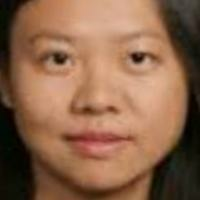

Gender female 



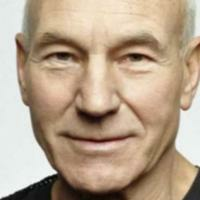

Gender male 



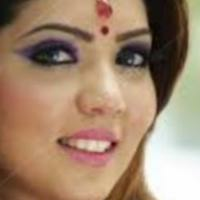

Gender female 



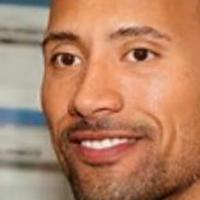

Gender male 



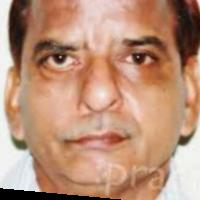

Gender male 



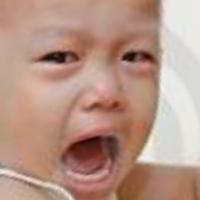

Gender male 



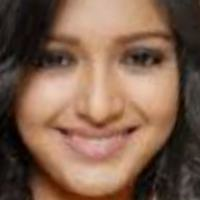

Gender female 



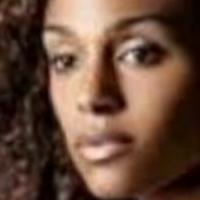

Gender female 



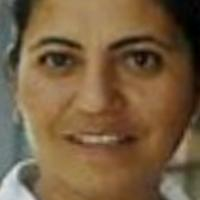

Gender female 



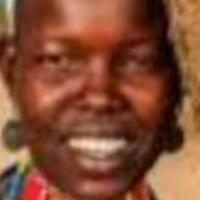

Gender female 



In [22]:
# Check a subset of images by displaying them along with their labels
for image, label in train_ds_gender.take(10):
    # Displays an image from its raw data.
    display(PIL.Image.fromarray(image.numpy()))
    print("Gender", GENDER_LABELS[label.numpy()], "\n")


In [23]:
#Preparing the training, testing and validating datasets. 
train_ds_gender = configure_for_performance(train_ds_gender)
val_ds_gender = configure_for_performance(val_ds_gender)
test_ds_gender = configure_for_performance(test_ds_gender)

In [24]:
#train the model with the balanced dataset
model = prepare_model(GENDER_INDEX)
compile_model(model, GENDER_INDEX)

model.fit(
    train_ds_gender,
    validation_data=val_ds_gender,
    epochs=3
)

Epoch 1/3
190/190 [==============================] - 120s 570ms/step - loss: 0.6586 - accuracy: 0.6529
Epoch 2/3
190/190 [==============================] - 105s 554ms/step - loss: 0.3622 - accuracy: 0.8408
Epoch 3/3
190/190 [==============================] - 109s 574ms/step - loss: 0.3141 - accuracy: 0.8629


In [25]:
#evaluating the performance of the balanced model
test_results = model.evaluate(test_ds_gender)
print(test_results)

149/149 [==============================] - 20s 132ms/step - loss: 0.3225 - accuracy: 0.8585
[0.3225088119506836, 0.8584686517715454]


In [26]:
#double check the performance of the balanced model
gender_results = get_detailed_results(test_ds, model, "gender")
display(gender_results.head())

# Create a dataframe containing only the rows where the condition is met--the classifier predicted correctly
correct = gender_results[gender_results["is_correct"] == True] 
incorrect = gender_results[gender_results["is_correct"] == False]

num_correct = float(correct.shape[0])
total = float(gender_results.shape[0])
print("Overall accuracy", num_correct / total)

age gender race                                     image_path is_correct
0  26      1    3  UTKFace\26_1_3_20170119193111002.jpg.chip.jpg       True
1  28      1    1  UTKFace\28_1_1_20170113012805025.jpg.chip.jpg       True
2  16      1    0  UTKFace\16_1_0_20170109214621700.jpg.chip.jpg       True
3  70      1    1  UTKFace\70_1_1_20170119205140215.jpg.chip.jpg      False
4  21      0    0  UTKFace\21_0_0_20170116201127126.jpg.chip.jpg       True

Overall accuracy 0.8584686774941995


__Visualize performance__

Now we're going to use the charting functions from earlier to compare the distributions of each attribute in the correct predictions to those in the incorrect predictions.

In [27]:
draw_pie(correct, "gender", "Gender - correct predictions", GENDER_LABELS)
draw_pie(incorrect, "gender", "Gender - incorrect predictions", GENDER_LABELS)

# Evaluating the accuracy of the model
The following functions are slightly modified their name of the model2 and each name of the helper functions

In [28]:
def get_prediction_binary(newModel,input_example):
    '''
        Converts the probability returned by the binary classifier to a class label
    '''
    predictions = (newModel.predict(input_example) > 0.5).astype("int32")
    return predictions[0][0]


def get_prediction_multiclass(newModel,input_example):
    '''
        Returns the predicted class (multi-class classification)
    '''
    prediction = np.argmax(newModel.predict(input_example), axis=-1)
    return prediction[0]


def get_prediction_linear(newModel,input_example):
    '''
        Returns the predicted value (linear regression)
    '''
    prediction = newModel.predict(input_example)
    return prediction[0][0]


def is_correct_categorical(predicted, actual):
    '''
        Checks if the predicted label matches the actual label (for categorical classification, either
        binary or multi-class)
    '''
    return predicted == actual


def is_correct_linear(predicted, actual, tolerance=0.5):
    '''
        Checks if the predicted value is within the actual value plus or minus the
        given tolerance. Default tolerance is 0.5.
    '''
    return predicted >= actual - tolerance and predicted <= actual + tolerance


def get_detailed_results(ds,newModel, predicted_attribute, tolerance=0.5):
    '''
        Gets predictions for each image in a dataset of file paths. predicted_attribute
        is a string describing the class the model is predicting e.g. gender. Returns a dataframe 
        containing all class labels and the outcome of the prediction (correct or not).
    '''
    COLS = ["age", "gender", "race", "image_path", "is_correct"]
    df = pd.DataFrame(columns=COLS)
    for image in ds:
        img_string = tf.io.read_file(image)
        img_data = tf.image.decode_jpeg(img_string, channels=3)
        img_expanded = np.expand_dims(img_data, axis=0)
        prediction = get_prediction_binary(newModel, img_expanded) if predicted_attribute == "gender" \
                     else get_prediction_multiclass(newModel, img_expanded) if predicted_attribute == "race" \
                     else get_prediction_linear(newModel, img_expanded)
        row = convert_file_path_to_df_row_dictionary(image.numpy(), COLS[0:3])
        row["image_path"] = image.numpy().decode("utf8")
        row["is_correct"] = is_correct_linear(prediction, row[predicted_attribute], tolerance) if predicted_attribute == "age" \
                            else is_correct_categorical(prediction, row[predicted_attribute])
        df = df.append(row, ignore_index=True)
    return df

# Create unbalanced gender dataset 73% male and 27% female

In [29]:
black_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_BLACK))
black_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_BLACK))
white_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_WHITE))
white_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_WHITE))
asian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_ASIAN))
asian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_ASIAN))
indian_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_INDIAN))
indian_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_INDIAN))
other_f_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_FEMALE, RACE_OTHER))
other_m_ds = train_ds.filter(lambda x: is_gender_and_race(x, GENDER_MALE, RACE_OTHER))

len_bf = len(list(black_f_ds.as_numpy_iterator()))
len_bm = len(list(black_m_ds.as_numpy_iterator()))
len_wf = len(list(white_f_ds.as_numpy_iterator()))
len_wm = len(list(white_m_ds.as_numpy_iterator()))
len_af = len(list(asian_f_ds.as_numpy_iterator()))
len_am = len(list(asian_m_ds.as_numpy_iterator()))
len_if = len(list(indian_f_ds.as_numpy_iterator()))
len_im = len(list(indian_m_ds.as_numpy_iterator()))
len_of = len(list(other_f_ds.as_numpy_iterator()))
len_om = len(list(other_m_ds.as_numpy_iterator()))

m = max(len_bm, len_wm,len_am,len_im,len_om)
f = min(len_bf, len_wf,len_af,len_if,len_of)

train_ds_unbalanced = black_f_ds.take(f) \
                    .concatenate(black_m_ds.take(m)) \
                    .concatenate(white_f_ds.take(f)) \
                    .concatenate(white_m_ds.take(m)) \
                    .concatenate(asian_f_ds.take(f)) \
                    .concatenate(asian_m_ds.take(m)) \
                    .concatenate(indian_f_ds.take(f)) \
                    .concatenate(indian_m_ds.take(m)) \
                    .concatenate(other_f_ds.take(f)) \
                    .concatenate(other_m_ds.take(m)) \
                    .shuffle(f * 10)

# New training set length - For some unknown reason, Tensorflow can't find the cardinality of the filtered dataset so...
new_train_size = len(list(train_ds_unbalanced.as_numpy_iterator()))
print("Balanced training set length:", new_train_size) # Quite a bit smaller!

Balanced training set length: 13583


In [30]:
# Split the train_val dataset into train (80% of the images) and validation (20%)
val_size_unbalanced = int(tf.data.experimental.cardinality(train_ds_unbalanced).numpy() * 0.2)
train_ds_unbalanced = train_ds_unbalanced.skip(val_size_unbalanced)
val_ds_unbalanced = train_ds_unbalanced.take(val_size_unbalanced)

In [31]:
#Create dataframe for the unbalanced train dataset.
unbalanced_df = create_dataframe_from_dataset(train_ds_unbalanced)

In [32]:
#Create visualizations for the unbalanced train dataset.
draw_pie(unbalanced_df, "gender", "Gender distribution - full dataset",GENDER_LABELS)
draw_pie(unbalanced_df, "race", "Race distribution - full dataset",RACE_LABELS)

In [33]:
# Create the image:label datasets for the train, validation, and test sets
train_ds_gender_unbalanced = train_ds_unbalanced.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_gender_unbalanced = val_ds_unbalanced.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)

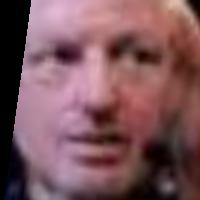

Gender male 



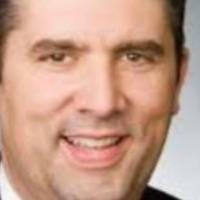

Gender male 



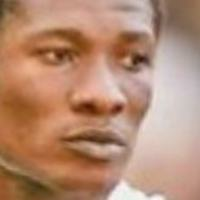

Gender male 



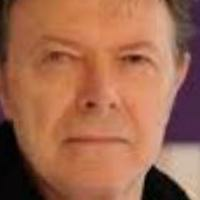

Gender male 



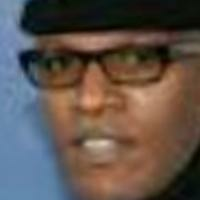

Gender male 



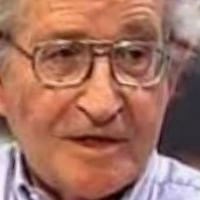

Gender male 



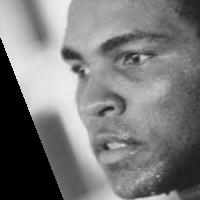

Gender male 



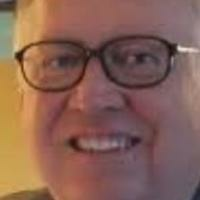

Gender male 



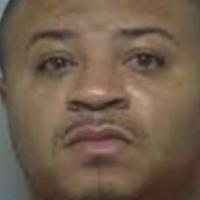

Gender male 



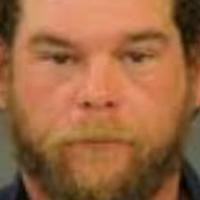

Gender male 



In [34]:
for image, label in train_ds_gender_unbalanced.take(10):
    # Displays an image from its raw data.
    display(PIL.Image.fromarray(image.numpy()))
    print("Gender", GENDER_LABELS[label.numpy()], "\n")


In [35]:
train_ds_gender_unbalanced = configure_for_performance(train_ds_gender_unbalanced)
val_ds_gender_unbalanced = configure_for_performance(val_ds_gender_unbalanced)


In [36]:
model2 = prepare_model(GENDER_INDEX)
compile_model(model2, GENDER_INDEX)

model2.fit(
    train_ds_gender_unbalanced,
    validation_data=val_ds_gender_unbalanced,
    epochs=3
)

Epoch 1/3
425/425 [==============================] - 280s 641ms/step - loss: 0.5208 - accuracy: 0.7913
Epoch 2/3
425/425 [==============================] - 290s 681ms/step - loss: 0.2664 - accuracy: 0.8882
Epoch 3/3
425/425 [==============================] - 280s 659ms/step - loss: 0.2226 - accuracy: 0.9104


In [37]:
test_ds_gender = test_ds.map(process_path_gender, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gender = configure_for_performance(test_ds_gender)
test_results_unbalanced = model2.evaluate(test_ds_gender)
print(test_results_unbalanced)

149/149 [==============================] - 22s 145ms/step - loss: 0.3343 - accuracy: 0.8553
[0.3343372344970703, 0.8553047776222229]


In [38]:
unbalanced_gender_results = get_detailed_results(test_ds, model2, "gender")
display(unbalanced_gender_results.head())

# Create a dataframe containing only the rows where the condition is met--the classifier predicted correctly
correct1= unbalanced_gender_results[unbalanced_gender_results["is_correct"] == True] 
incorrect1= unbalanced_gender_results[unbalanced_gender_results["is_correct"] == False]

age gender race                                     image_path is_correct
0  26      1    3  UTKFace\26_1_3_20170119193111002.jpg.chip.jpg       True
1  28      1    1  UTKFace\28_1_1_20170113012805025.jpg.chip.jpg       True
2  16      1    0  UTKFace\16_1_0_20170109214621700.jpg.chip.jpg       True
3  70      1    1  UTKFace\70_1_1_20170119205140215.jpg.chip.jpg      False
4  21      0    0  UTKFace\21_0_0_20170116201127126.jpg.chip.jpg       True

In [39]:
num_correct1 = float(correct1.shape[0])
total1 = float(unbalanced_gender_results.shape[0])
print("Overall accuracy", num_correct1 / total1)

Overall accuracy 0.8553047880194052


In [40]:
draw_pie(correct1, "gender", "Gender - correct predictions", GENDER_LABELS)
draw_pie(incorrect1, "gender", "Gender - incorrect predictions", GENDER_LABELS)


# Conclusion
According to the result of the balanced model, 51.2% male and 48.8% female are correctly predicted whereas the unbalanced showed that 54.5% male and 45.5% female are correctly classified. However, the incorrect results represent as significant different between two models. Particularly, the female is more likely to be misclassified (61.3%) due to the unbalanced gender dataset while this result was 42.2% in the balanced model. Thus, my hypothesis is correct because the balanced model is more consistent than the unbalanced one.   